# Clustering

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

df=pd.set_option('display.max_columns',None)

In [323]:
df_train=pd.read_csv('train.csv')
df_train.head()

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,worstRating,bestRating,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isRatable,isAdult,numRegions,userReviewsTotal,ratingCount,countryOfOrigin,genres
0,Neogenic Nightmare Chapter 3: Hydro-Man,"(7, 8]",1995,\N,\N,0.0,779,1,10,1,0,21,1,tvEpisode,0,False,True,0,1,0,781,['US'],"Action,Adventure,Animation"
1,Looping,"(5, 6]",1982,\N,\N,0.0,11,1,10,1,0,1,0,videoGame,0,False,True,0,1,0,11,['XWG'],Action
2,Idealnaya para,"(5, 6]",1992,\N,\N,0.0,38,1,10,1,0,24,0,movie,0,False,True,0,1,1,38,['RU'],Comedy
3,MasterChef Celebrity México,"(5, 6]",2021,\N,\N,0.0,15,1,10,22,0,56,0,tvSeries,0,True,True,0,1,0,15,['MX'],Reality-TV
4,Seutateueob,"(7, 8]",2020,2020,80,1.0,15718,1,10,347,2,47,4,tvSeries,1,True,True,0,32,452,15746,['KR'],"Comedy,Drama,Romance"


# Preprocessing

In [324]:
df_train['rating'] = df_train['rating'].astype(str).str.extract(r'\((\d+),\s*(\d+)\]')[1].astype(float)

Filling Missing Values

In [325]:
df_train['runtimeMinutes'] = pd.to_numeric(df_train['runtimeMinutes'], errors='coerce')  # Ensure it's numeric
df_train['runtimeMinutes'] = df_train['runtimeMinutes'].fillna(df_train['runtimeMinutes'].mode()[0])  # Fill NaN

In [326]:
df_train['awardWins'] = pd.to_numeric(df_train['awardWins'], errors='coerce')   # Ensure it's numeric
df_train['awardWins'] = df_train['awardWins'].fillna(df_train['awardWins'].mode()[0])  # Fill NaN

Converting Categorical data

In [327]:
title_type=sorted(df_train['titleType'].unique())
title_type_mapping =dict(zip(title_type, range( 0, len(title_type)+1)))
df_train['titleType_Val']=df_train['titleType'].map(title_type_mapping).astype(int)

feature reduction

In [328]:
df_train.drop(columns=['originalTitle','bestRating','worstRating','isRatable','countryOfOrigin'\
                ,'genres'  ,'endYear'],axis=1, inplace=True)

oulier reduction

In [329]:
df_train.shape

(16431, 17)

In [392]:
# Select only numeric columns
numeric_cols = df_train.select_dtypes(include=[int, float])

# Compute IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create mask for filtering numeric rows
mask = ~((numeric_cols < lower_bound) | (numeric_cols > upper_bound)).any(axis=1)

# Apply mask to full dataset (retain categorical columns)
df_tr = df_train[mask]

In [393]:
df_tr.shape

(7832, 17)

In [395]:
df_tr=df_tr.select_dtypes(include=[int, float])

In [396]:
df_tr.shape

(7832, 15)

# KMEANS

In [404]:
scaler= MinMaxScaler()
t_data = scaler.fit_transform(df_tr)

In [406]:
%%time
sse_list = []
sil_list = []

for k in range(2, 21):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(t_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(t_data, kmeans.labels_))

CPU times: total: 59.5 s
Wall time: 42.6 s


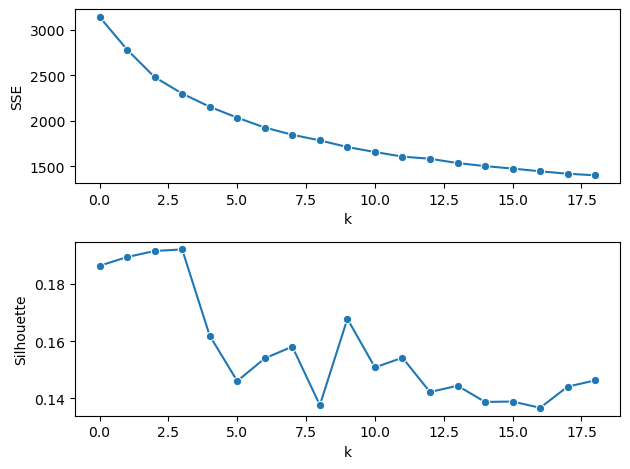

In [407]:
fig, axs = plt.subplots(2) # 1 row, 2 columns

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')
sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

In [488]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10, max_iter=100)
kmeans.fit(t_data)

KMeans(max_iter=100, n_clusters=3, n_init=10)

In [489]:
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(t_data, kmeans.labels_))

labels (array([0, 1, 2]), array([2518, 4284, 1030], dtype=int64))
sse 2780.373519014706
silhouette 0.18945150075084863


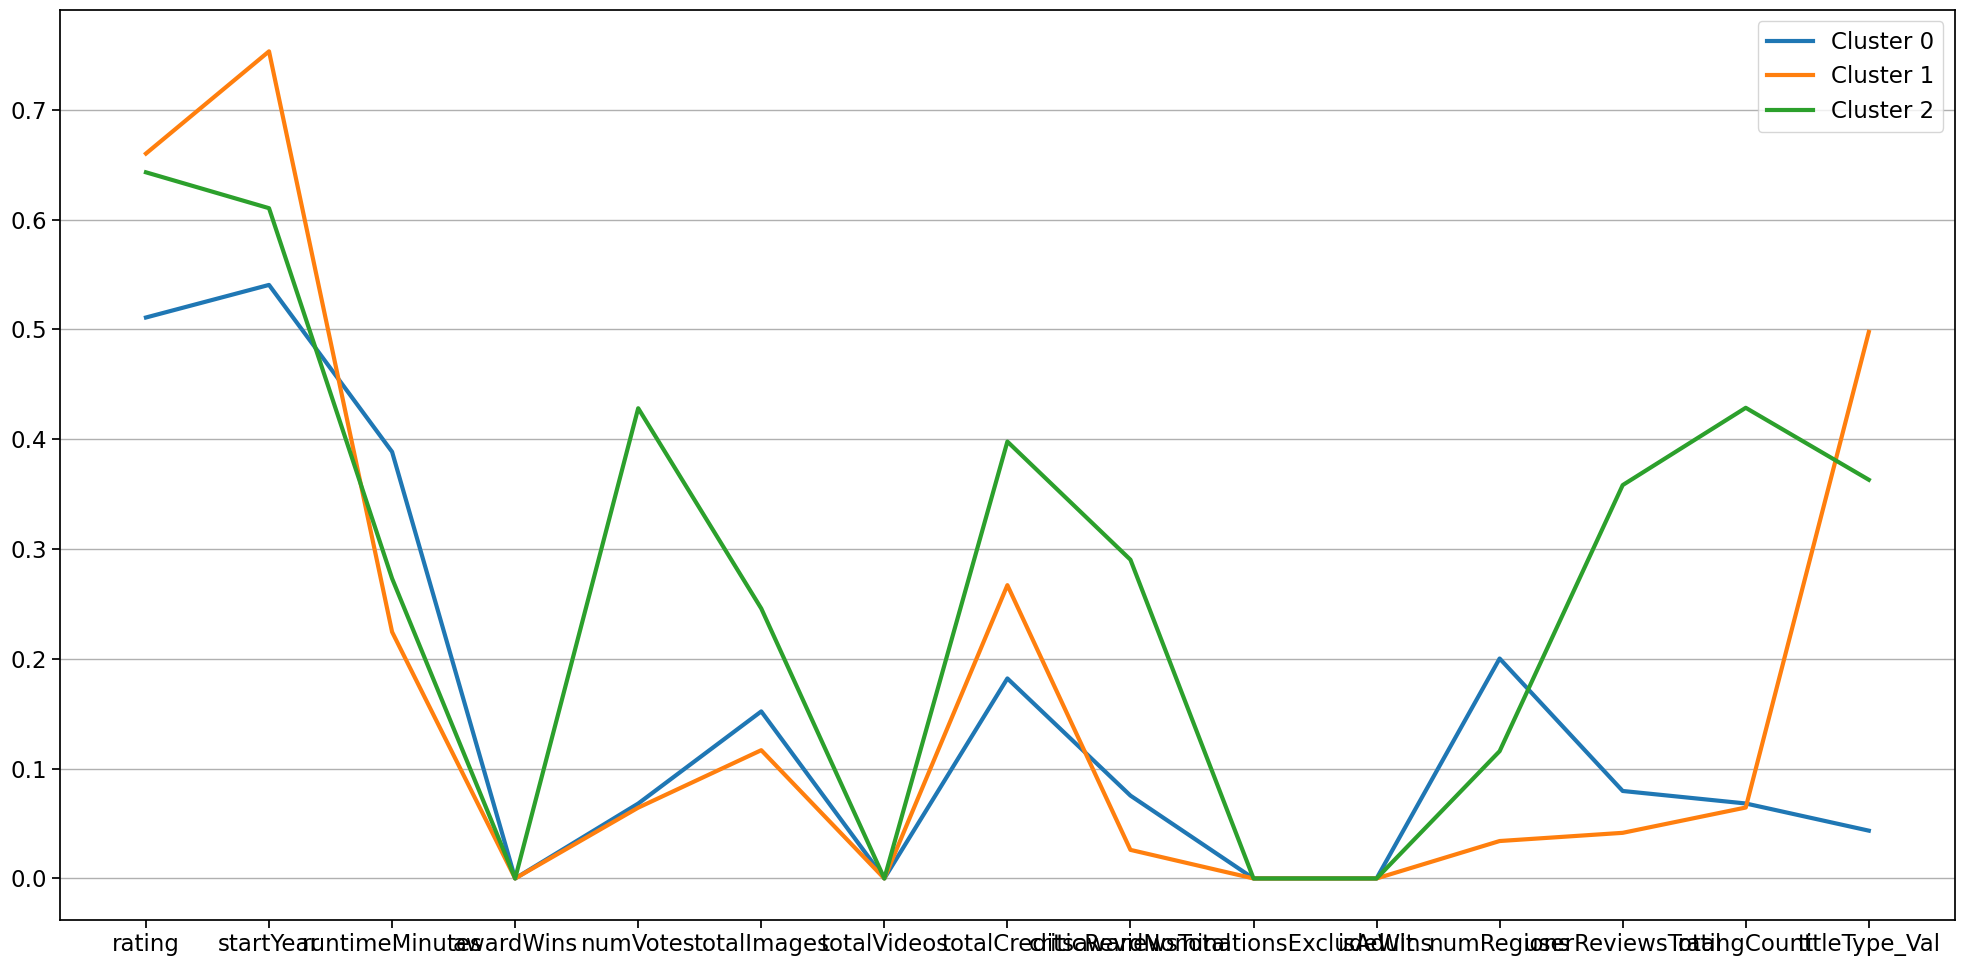

In [490]:
plt.figure(figsize=(20, 10))

for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 15), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(0, 15), list(df_tr.columns))
plt.legend(bbox_to_anchor=(1,1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [491]:
df_clusters = df_tr.copy()
df_clusters['Labels'] = kmeans.labels_

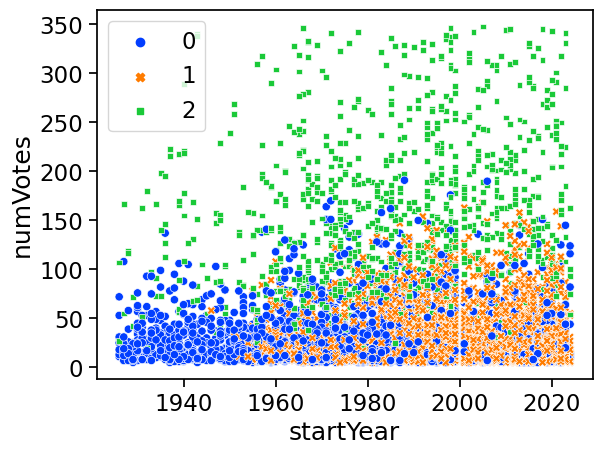

In [492]:
sns.scatterplot(data=df_clusters, 
                x="startYear",
                y="numVotes", 
                hue=kmeans.labels_, 
                style=kmeans.labels_, 
                palette="bright")
plt.show()

In [417]:
df_clusters.head()

,rating,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,awardNominationsExcludeWins,isAdult,numRegions,userReviewsTotal,ratingCount,titleType_Val,Labels
2,6.0,1992,30.0,0.0,38,1,0,24,0,0,0,1,1,38,0,1
6,8.0,1995,45.0,0.0,96,5,0,110,0,0,0,1,0,96,2,0
9,9.0,2022,30.0,0.0,27,9,0,15,0,0,0,1,0,27,3,0
10,9.0,2017,44.0,0.0,33,1,0,5,0,0,0,1,0,33,4,0
12,7.0,1965,60.0,0.0,24,1,0,36,0,0,0,3,0,24,0,1


In [469]:
isAdult_xt = pd.crosstab(df_clusters['isAdult'], df_clusters['Labels'])
isAdult_xt

Labels,0,1,2
isAdult,,,
0,4284,2518,1030


In [470]:
tt_xt = pd.crosstab(df_clusters['titleType_Val'], df_clusters['Labels'])
tt_xt 

Labels,0,1,2
titleType_Val,,,
0,22,1990,153
1,747,508,114
2,2321,20,669
3,98,0,4
4,502,0,44
5,594,0,46


In [471]:
tt_xt = pd.crosstab(df_clusters['rating'], df_clusters['Labels'])
tt_xt 

Labels,0,1,2
rating,,,
3.0,25,30,3
4.0,52,141,10
5.0,148,293,41
6.0,446,701,109
7.0,1105,763,260
8.0,1521,443,469
9.0,822,121,133
10.0,165,26,5


In [473]:
tt_xt = pd.crosstab(df_clusters['rating'], df_clusters['Labels'])
tt_xt 

Labels,0,1,2
rating,,,
3.0,25,30,3
4.0,52,141,10
5.0,148,293,41
6.0,446,701,109
7.0,1105,763,260
8.0,1521,443,469
9.0,822,121,133
10.0,165,26,5


# Hierarchical

In [475]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [476]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='complete')
model = model.fit(t_data)

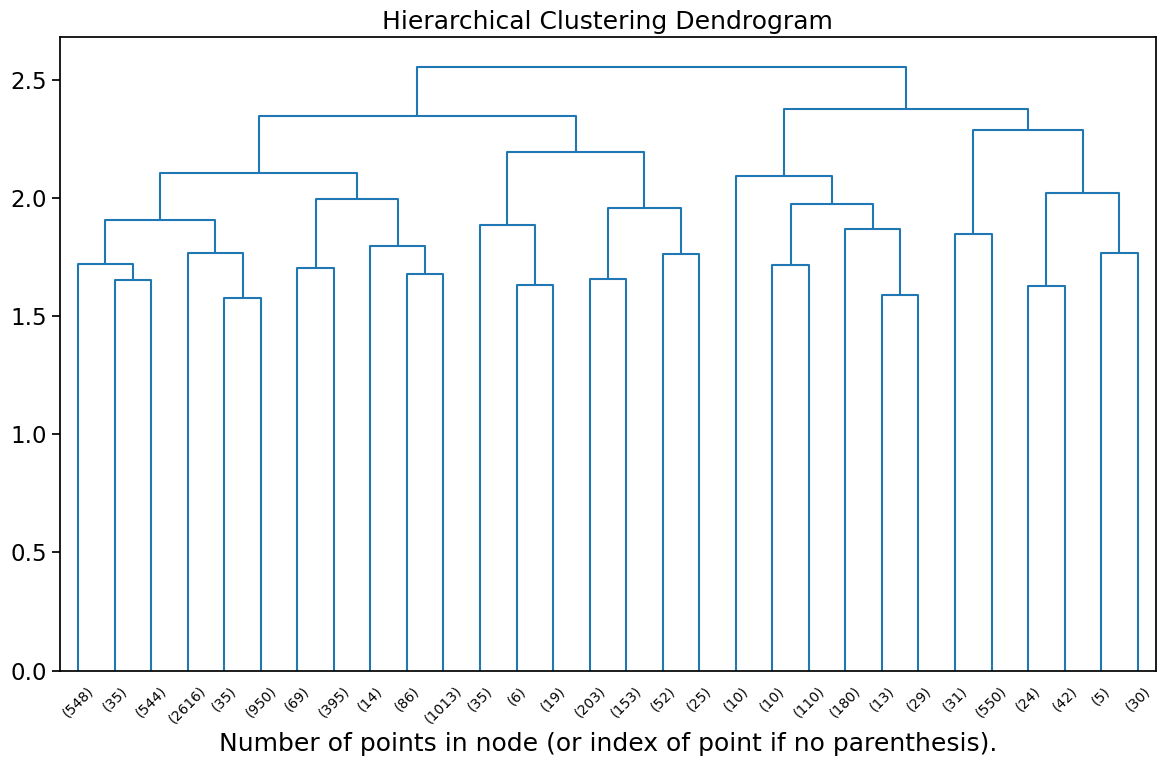

In [479]:
plt.figure(figsize=(12, 8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=1.2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.tight_layout()
plt.show()

In [480]:
# get the labels according to a specific threshold value cut
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=1.2, criterion='distance')

In [481]:
labels

array([17, 23, 30, ..., 49, 17, 16], dtype=int32)

In [482]:
print('Silhouette', silhouette_score(t_data, labels))

Silhouette 0.10529686356384048


In [483]:
hier = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
hier.fit(t_data)

AgglomerativeClustering(linkage='complete', metric='euclidean', n_clusters=3)

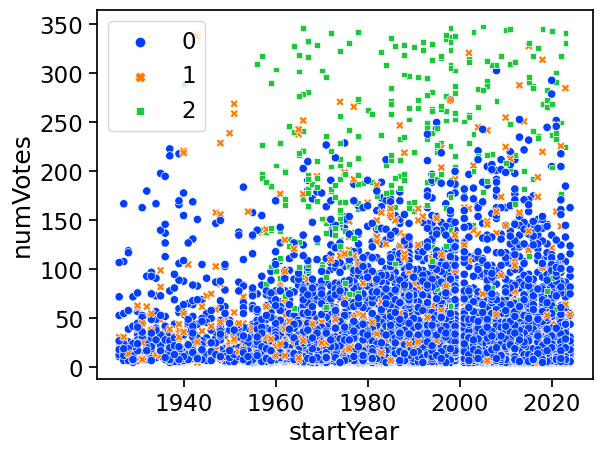

In [486]:
sns.scatterplot(data=df_clusters, 
                x="startYear", 
                y="numVotes", 
                hue=hier.labels_, 
                style=hier.labels_, 
                palette="bright")
plt.show()